# <b>Room-Temp. NV Experimental Control Notebook</b>

<b>Introduction:</b>  
This Jupyter Lab notebook controls the room-temp. NV experimental setup on the second optical bench in B00 within the Lukin Group. This experiment contains a laser scanning confocal microscope to study 2D materials. The confocal microscope uses a 100$x$ objective and a fiber-coupled excitation laser at 635 $n$m. The experiment is controlled by a National Instruments (NI) data-acquisition card, specifically the NI-cDAQ series (model 9174). This DAQ contains two cards/modules: 1. the NI-9402 module which contains four bi-directional digital input/output (I/O) channels -also featuring programmable internal clocks for counting. And 2. the NI-9263 module which contains four analog output channels (-10 V to +10 V).

This notebook functions as the experimental control software for this room-temp NV measurement setup. This notebook implements the [CoDeS](https://qcodes.github.io/https://qcodes.github.io/) data-acquisition framework written by the Copenhagen/Delft/Sydney/Microsoft quantum computing consortium. QCoDeS is a Python-based framework that uses imported functions and databses to carry about measurements. Additional files are imported within the "Imports" section; including the [NI-DAQmx](https://nidaqmx-python.readthedocs.io/en/latest/https://nidaqmx-python.readthedocs.io/en/latest/) framework which uses Python C-type wrappers to communicate with the NI DAQ card. The basic use of this notebook is as follows: "instruments" such as the NI-9402 and NI-9263 module (or mode added at a later date) are created using the internal QCoDeS methods. From here, a "database", "station", and an "experiment" are created also following the QCoDeS context. Then diferent measurements can be written and run using the reviously initialized instruments -populating a database for analysis and plotting. This notebook is meant to be continually added to. Measurements will be run, parameters will be changed, and each iteration (experimental run) is carried out within the "Measurement" section below; then analized and visualized within the "Analysis" section.

<b>Helful notes when learning this control framework for the first time:</b>
1. The NI-cDAQ card (chasis) is called (this can be changed using the NI-MAX software when the NI-DAQ card is connect to this computer) "cDAQ1". Additional info. about the cDAQ device and its inserted modules (as of 081522 only ni_9402 and ni_9263) can be viewed in the NI-MAX software. This software opens automatically when the cDAQ device is connected to <em>this</em> computer
2. The first module inserted into the cDAQ card (the NI-9402 module) is called "mod1". This naming pattern follows the available slots within the cDAQ chasis (there are four available slots)
3. The second module in the cDAQ chasis (the NI-9263 module) is called "mod2" following in suit
4. The QCoDeS "experiment_name" is "room_temp_NV_exp_control_experimentroom_temp_NV_exp_control_experiment"
5. The QCoDeS "database_name" is "room_temp_NV_exp_control_databaseroom_temp_NV_exp_control_database"
6. The QCoDeS "station_name" is "room_temp_NV_exp_control_stationroom_temp_NV_exp_control_station"

Notebook timeline:
071022 $\rightarrow$ 081522  

Initial author: Miles D. Ackerman (undergraduate during summer of 2022)

## Preliminaries

___

The below cells in this section contain code referenced before any other setup. This is the preamble for this notebook allowing ease of editing for referenced files that are called in this notebook.

### Auto-relaod for editing imported files (packages)

This short series of commands does not need to be run if starting from the top of this notebook. It will automatically reference the most recently saved edited files imported below.

In [1]:
# auto-reload commands
%load_ext autoreload
%autoreload 2

### Closing created instruments (modules)

Use if starting from the top of the notebook only. Otherwise, already initialized instruments will be lost and MUST be re-created before any measurement can be made.

In [2]:
# TODO: fix both below code cells for closing instruments
# goal: close instruments only if open to prevent accidentally closing instruments

# try:
#     ni_9402.close, ni_9263.close()
# except NameError:
#     print("already clsoed")

In [4]:
# closing the ni_9402 module (first slot within the NI-cDAQ)
ni_9402.close()

NameError: name 'ni_9402' is not defined

In [5]:
# closing the ni_9263 module (second slot within the NI-cDAQ)
ni_9263.close()

NameError: name 'ni_9263' is not defined

## Importing  required modules

___

This below cell contains all of the referenced imports (files/modules) used in this experimental control notebook.

In [6]:
# overall imports
import numpy as np
import qcodes as qc
import nidaqmx
import os
from time import sleep
from tqdm.notebook import trange, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

# qcodes dataset imports
from qcodes.dataset import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)

# import qcodes contrib_drivers NI package (all)
from qcodes_contrib_drivers.drivers.NationalInstruments.DAQ import *

# import mulit-D scanning module (from QCoDeS)
from qcodes.utils.dataset.doNd import (
    dond,
    LinSweep,
    do1d
)

# import plotting module (from QCoDeS)
from qcodes.dataset.plotting import plot_dataset

# import interactive widget from QCoDeS
from qcodes.interactive_widget import experiments_widget

# other imports
%matplotlib inline
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.instrument.parameter import Parameter
from qcodes.dataset import initialise_or_create_database_at
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes import Station, initialise_or_create_database_at, \
    load_or_create_experiment, Measurement
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.loops import Loop
from qcodes.plots.pyqtgraph import QtPlot

In [ ]:
# TODO: some of the above imports are not currently used in this eperiment control (as of 081522)

In [ ]:
# TODO: QCoDeS logging?
# https://qcodes.github.io/Qcodes/examples/logging/logging_example.html

# include QCoDeS logging above?

## Creating instruments

___

The below cells initialize each instrument (hardware cards inserted into the cDAQ) to be used for measurement.

### Creating the ni_9402 instrument (slot one in the cDAQ card)

This module's info. can be found at: [https://www.ni.com/en-us/support/model.ni-9402.htmlhttps://www.ni.com/en-us/support/model.ni-9402.html](NI-9402). This module functions as a counter based on an internal clock within the module. The first part of the below cell defines all of the avilable parameters for creating a counter assigned to this module. The counter requires the use of two of the four available channels on this cDAQ card. One channel is for input (from the APD on the optical bench), and one channel for the hardware-timed clock to "run" the counter. Currently (as of 081522) only one counter (analog input) channel can be created at a time. In order to change this functionality, the source code for this contributed drivers package must be edited.

In [7]:
# def the parameters of the instrument
ni_9402_device_name = "cDAQ1Mod1"
ni_9402_counter_channel = "cDAQ1Mod1/ctr0"
ni_9402_clock_channel = "cDAQ1Mod1/ctr1"
ni_9402_source_channel = "/cDAQ1/Ctr1InternalOutput"
ni_9402_sampling_rate = 1000
ni_9402_samples_per_channel = 1
ni_9402_duty_cycle = 0.5
ni_9402_integration_time = 0.3
ni_9402_timeout = 0.01

# creating the instrument for mod1
ni_9402 = Counter("ni_9402_module", ni_9402_device_name, ni_9402_counter_channel,
    ni_9402_clock_channel, ni_9402_source_channel, ni_9402_sampling_rate,
    ni_9402_samples_per_channel, ni_9402_duty_cycle,
    ni_9402_integration_time, ni_9402_timeout
    )

In [ ]:
# TODO: allow for multiple counter input channels (can more than one counter input channel be liked to the same hardware-timed referene clock?)
# This should function as the NI-9263 ao_channels initializations statement -a list of available channels to reference instead of one defined one as above

### creating ni_9263 instrument (slot two in the cDAQ chasis)

This module's info can be found at: [https://www.ni.com/en-us/support/model.ni-9263.htmlhttps://www.ni.com/en-us/support/model.ni-9263.html](NI-9263). This moduel is used for programmable digital output. This functionality is largely used for controlling the servo motors on the ThorLab's galvo (by writing a sequence of voltages to them -see "Galvo scan" for more info.). Here, all available digital output channels are created in one line: `ni_9263_ao_channels` where a single channel can be accessed at a time.

In [8]:
# naming the instrument
ni_9263_device_name = "cDAQ1Mod2"

# dictionary of analog output channels
ni_9263_ao_channels = {f'{ni_9263_device_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
ni_9263 = DAQAnalogOutputs("ni_9263_module", ni_9263_device_name, ni_9263_ao_channels)

## Getting instrument snapshots

___

This verifies required parameters are setup properly verifies required parameters are setup properly

### ni_9402 module (cDAQ1 slot one) snapshot

In [9]:
# get ni_9402 snapshot
ni_9402.print_readable_snapshot()

ni_9402_module:
	parameter                 value
--------------------------------------------------------------------------------
IDN                        :	None 
integrateavg               :	None (#)
read_counter_cdaq1mod1ctr0 :	None (#)


### ni_9263 (cDAQ1 slot two) module snapshot

In [10]:
# get ni_9263 snapshot
ni_9263.print_readable_snapshot()

ni_9263_module:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	None 
voltage_cdaq1mod2ao0 :	None (V)
voltage_cdaq1mod2ao1 :	None (V)
voltage_cdaq1mod2ao2 :	None (V)
voltage_cdaq1mod2ao3 :	None (V)


## Creating a station

___

This follows the QCoDeS framework to create a station for running measurements. Previously initializied instruments can be (are) added to the station in order to be referenced later using other functions.

In [11]:
# create the station at the designated name
room_temp_NV_exp_control_station = qc.Station()

### Adding the ni_9402 instrument to the station

In [12]:
# add ni_9402_module to station
room_temp_NV_exp_control_station.add_component(ni_9402)

#TODO: fix the IDN error here

[ni_9402_module(Counter)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 640, in get_idn
    idstr = self.ask('*IDN?')
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 961, in ask
    raise e
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 954, in ask
    answer = self.ask_raw(cmd)
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 974, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument Counter has not defined an ask method', "asking '*IDN?' to <Counter: ni_9402_module>")
[ni_9402_module(Counter)] Snapshot: Could not update parameter: read_counter_cdaq1mod1ctr0
[ni_9402_module(Counter)] Snapshot: Could not update parameter: integrateavg


'ni_9402_module'

### Adding the ni_9263 instrument to the station

In [13]:
# add ni_9263 to station
room_temp_NV_exp_control_station.add_component(ni_9263)

#TODO: fix the IDN error here

[ni_9263_module(DAQAnalogOutputs)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 640, in get_idn
    idstr = self.ask('*IDN?')
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 961, in ask
    raise e
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 954, in ask
    answer = self.ask_raw(cmd)
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 974, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument DAQAnalogOutputs has not defined an ask method', "asking '*IDN?' to <DAQAnalogOutputs: ni_9263_module>")


'ni_9263_module'

### Getting the whole station snapshot

This cell outputs all of the accessible info. corresponding to the user-defined instruments.

In [20]:
# calling to view station snapshot
_=room_temp_NV_exp_control_station.snapshot()# can addd "_ = " at beginning to supress long output

## Creating a databaase

___

This is where all measurement and recorded data is written to. This data can be accessed in a number of ways but first must have a storage place designated. Multiple databases can be created and accessed

### Initialize the database for later use

In [15]:
# create the database. "initialise" also functions to load a previously created database. Multiple databases can be created
# as of 081522 only one database has been created (used for writing this notebook and testing)
initialise_or_create_database_at("~/room_temp_NV_exp_control_database.db")

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.06it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


### Confirming the database location on THIS computer

In [16]:
# testing database location on THIS computer
qc.config.core.db_location

'~/room_temp_NV_exp_control_database.db'

## Creating an experiment

___

This is the last cell following the notebook outline from QCoDeS. This "experiment" is used for running measurements later along with the instruments, station, and database

### Initilize the experiment

In [17]:
# setting up experiment name and experiment data
room_temp_NV_exp_control_experiment = load_or_create_experiment(
    experiment_name = "room_temp_NV_exp_control_experiment",
    sample_name = "room_temp_NV_exp_control_experiment_data"
)

## Measurement

___

Below this cells starts the measurement section for this experiment. This is where new measurements will be created and run. Analysis of measurements (including plotting of data can be carried out in the last section of this notebook -"Analysis"). Taking measurements follow this proces: ADD INFO HERE. The different types of measurements are numbered as written below. When analyzing data from one of these measurements, refer to the corresponding section in "Analysis".

### Reading from the chosen counter channel (Measurement)

This measurement section soley reads data from the chosen counter channel (this counter channel was initialized when the instrument, NI-9402 was created above in "Creating Instruments"). Within this section are code cells for reading a single sample from the counter and for reading a finite number of samples from the channel.

#### 1. Reading a single sample from the chosen counter channel (Measurement)

Read a single sample from the chosen counter (this returns a result based on the pre-set parameters when the instrument was created). No parameters for this measurement can be changed here.

In [85]:
# setup the measurement
counter_single_sample_meas = Measurement(
    exp = room_temp_NV_exp_control_experiment,
    station = room_temp_NV_exp_control_station,
    name = "counter_single_sample_meas"
    )

# register a parameter to the above measurement
counter_single_sample_meas.register_parameter(ni_9402.read_counter_cdaq1mod1ctr0)

# run the measurement (read the counter value)
with counter_single_sample_meas.run() as datasaver:
    result_test = ni_9402.read_counter_cdaq1mod1ctr0()

    # saving the single read counter value to a user-named dataset
    counter_single_sample_dataset = datasaver.dataset

Starting experimental run with id: 32. 


#### 2. Reading a finite number of smaples from the chosen counter channel (Measurement)

This measurement reads a finite number of samples from the ni_9402 module counter channel (the selected channel was defined when the instrument was created in "Instruments"). The parameters defined when the ni_9402 insturment was created still apply here (e.g. sampling rate). Only the number of samples to acquire from the counter can be changed here

In [94]:
# setup parameters for the finite measurement
counter_value_to_read = ni_9402.read_counter_cdaq1mod1ctr0
time = ElapsedTimeParameter("time")

# user-defined variable for the measurement
num_counter_values_to_read = 50

# setup the measurement
counter_finite_samples_meas = Measurement(
    exp = room_temp_NV_exp_control_experiment,
    station = room_temp_NV_exp_control_station,
    name = "counter_finite_samples_meas"
    )

# registering defined parameters to the measurement (counter_finite_samples_meas)
counter_finite_samples_meas.register_parameter(time)
counter_finite_samples_meas.register_parameter(counter_values, setpoints = [time])

# loop to read finite number of values from counter
with counter_finite_samples_meas.run() as datasaver:
    
    # before loop statements
    counter_values_list = 0
    time.reset_clock()
    
    # measurement loop
    for i in trange(num_counter_values_to_read, desc = "scan progress"): # use tqdm for progress bar
        counter_values_list += counter_value_to_read()
        current_time = time()
        datasaver.add_result((counter_value_to_read, counter_values_list), (time, current_time))

# save to user-defined/named dataset for later viewing
counter_finite_samples_dataset = datasaver.dataset

Starting experimental run with id: 37. 


scan progress:   0%|          | 0/50 [00:00<?, ?it/s]

### Galvo scanning (Measurement)

This section contains the measurement code cells for galvo scanning. Are there different types?

#### 1. Galvo scan: using the galvo in the confocal microscope (Measurement)

Text

In [95]:
# reset galvo cell (to 0 V)

# x-mirror
ni_9263.voltage_cdaq1mod2ao0(0)

# y-mirror
ni_9263.voltage_cdaq1mod2ao1(0)

In [ ]:
# galvo check cell:

for i in range(30):
    ni_9263.voltage_cdaq1mod2ao0(10), ni_9263.voltage_cdaq1mod2ao1(10)
    sleep(1)
    ni_9263.voltage_cdaq1mod2ao0(0), ni_9263.voltage_cdaq1mod2ao1(0)
    sleep(1)

scan progress:   0%|          | 0/8 [00:00<?, ?it/s]

motor step voltage: 0.01 V
counter read time per point: 0.0001 s
num points collected: 64
elapsed scanning time: 9.7 s

dataset:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

plot:


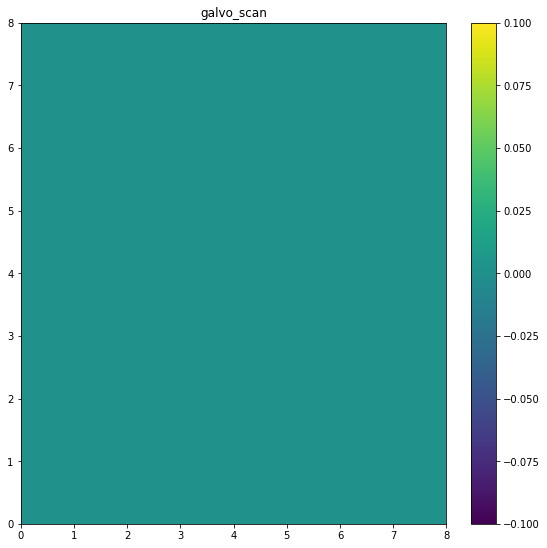

In [102]:
#################### resetting position of mirrors ####################

# x-mirror
ni_9263.voltage_cdaq1mod2ao0(0)

# y-mirror
ni_9263.voltage_cdaq1mod2ao1(0)

#################### delay to watch sweeping ####################

# sleep(13)

#################### setting variales and array ####################

# get time @ start of scanning
start_time = time()

# initial driving voltage for x
drive_voltage_x = 0.0

# initial driving voltage for y
drive_voltage_y = 0.0

# drive voltage step for sweep
drive_voltage_step = 0.01

# def size of grid to scan (array is square)
grid_size = 8

# set delay in seconds (time to let counter accumulate per point)
delay_time = 0.0001

# create dataset to populate
data_array = np.zeros((grid_size, grid_size))

#################### looping over grid (scanning) ####################

# scan over array reading counter @ each point
for k in trange(grid_size, desc = "scan progress"): # y rows
    
    for i in range(grid_size): # x cols
        
        ni_9263.voltage_cdaq1mod2ao0(drive_voltage_x) # moving on x motor
        sleep(delay_time)
        
        result = ni_9402.read_counter_cdaq1mod1ctr0() # reading counter
        
        if k == 1 & i == 1: # correcting counter values point to point
            result == data_array[k][i]
        else:
            result == data_array[k][i] - data_array[k - 1][i - 1]
            
        if k % 2 != 0: # correcting for sweeping back AND forth on x
            drive_voltage_x -= drive_voltage_step
        else:
            drive_voltage_x += drive_voltage_step # stepping x voltage
            
    ni_9263.voltage_cdaq1mod2ao1(drive_voltage_y) # moving on y motor
    drive_voltage_y += drive_voltage_step # stepping y voltage
    sleep(delay_time) # correcting delay for edge data points

#################### displaying dataset info. ####################

# printing parameters
print("motor step voltage: %s V" % str(drive_voltage_step))
print("counter read time per point: " + str(delay_time) + " s")
print("num points collected: %s" % (str(grid_size * grid_size)))
print("elapsed scanning time: %.1f s" % (time() - start_time) + "\n")

# printing dataset
print("dataset:\n" + str(data_array))

# plotting dataset
print("\nplot:")
fig, axs = plt.subplots(figsize = (7.5, 7.5), layout = "constrained")
plot1 = axs.pcolormesh(data_array)
fig.colorbar(plot1, ax = axs)
axs.set_title("galvo_scan");

## Analysis

___

This section is where the data obtained from above measurements is carried out. The numbering scheme below should correspond to the different numbered measurements above.

### Reading from the chosen counter channel (Analysis)

Basic analysis for two counter measurements.

#### 1. Reading a single sample from the chosen counter channel (Analysis)

This section will return the single read result measurements from the counter.

In [87]:
# displaying the single result from the counter
print("counter value = %s" % str(result_test))

counter value = 0.0


#### 2. Reading a finite number of smaples from the chosen counter channel (Analysis)

This section will return the results of measurements that acquired a finite number of samples from the counter.

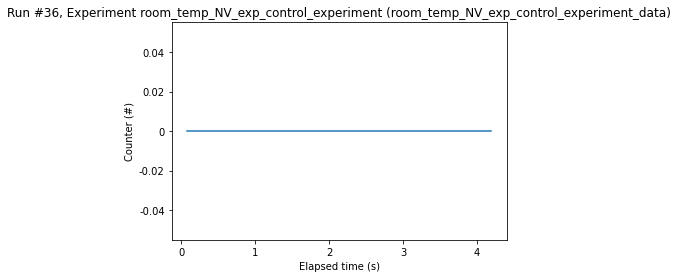

In [93]:
# using the QCoDeS internal plotting functionality (`plot_dataset`) to visualize the measurement caried out in an above cell
axs, cbs = plot_dataset(counter_finite_samples_dataset)

# TODO: additional plotting parameters? Plot window size?
# TODO: add a comment or note somewhere about the automatic plot labeling according to the measurement (the measurement parameters)

### Galvo scanning (Analysis)

Analysis section for galvo scanning measurements.

#### 1. Galvo scan generic(?) (Analysis)

In [100]:
print("fill in")

fill in
